In [1]:
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import preprocessing
import scipy.io
from tensorflow.keras import layers
import mne
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

2023-04-08 23:28:20.032454: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
#load data from ../EEG folder, all csv files
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

def get_data():
    data = []
    scores = []
    order = []
    filedir = '/mnt/Ryans Study/EEG'
    for file in [f for f in os.listdir(filedir) if f.endswith(".fif") and not f.endswith("resting.fif")]:
        filepath = filedir + "/" + file
        print(file)
        # get number from file name
        order.append(int(file.split("_")[0]))
        # load raw file
        raw = mne.io.read_raw_fif(filepath, preload=True)
        # get data
        data.append(raw.get_data(picks=['Fp1','Fp2'])[:, 7500:-15000])
        # get scores from file names, 1 = watching, 2 = normal, 3 = hard
        if "watching" in file or "watch" in file:
            scores.append(0)
        elif "normal" in file or "correct" in file:
            scores.append(1)
        elif "hard" in file:
            scores.append(2)

    return data, scores, order


def remove_participant(data, scores, order, participant):
    newdata = []
    newscores = []
    removed_participant = []
    removed_scores = []

    for x, y, z in zip(data, scores, order):
        if z != participant:
            newdata.append(x)
            newscores.append(y)
        else:
            removed_participant.append(x)
            removed_scores.append(y)

    return np.array(newdata), np.array(newscores), np.array(removed_participant), np.array(removed_scores)


def split_timeseries(series, window_size=1000, overlap=100):
    segments = []
    for i in range(0, series.shape[-1] - window_size + 1, window_size - overlap):
        segment = series[..., i:i + window_size]
        # add extra dimension for channel
        x_max = np.max(segment)
        x_avg = np.mean(segment)
        segment = (segment - x_avg) / x_max
        segment = np.expand_dims(segment, axis=-1)
        segments.append(segment)
    return segments


# split data into 1000 sample sliding window with 100 sample overlap
def split_data(data, scores, order, window_size=1000, overlap=100):
    X = []
    Y = []
    neworder = []
    for x, y, z in zip(data, scores, order):
        x = split_timeseries(x, window_size, overlap)
        X.extend(x)
        Y.extend([y] * len(x))
        neworder.extend([z] * len(x))
    return X, Y, neworder


def remove_nan(data, scores, order):
    # if series contains nan, remove it
    newdata = []
    newscores = []
    neworder = []
    for x, y, z in zip(data, scores, order):
        if np.isnan(x).any():
            continue
        else:
            newdata.append(x)
            newscores.append(y)
            neworder.append(z)
    return newdata, newscores, neworder


# def model
def EEGNet_seq(nb_classes, Chans=64, Samples=128,
               dropoutRate=0.5, kernLength=64, F1=8,
               D=2, F2=16, norm_rate=0.25, dropoutType='Dropout',
               learning_rate=3e-3, loss="mse"):
    """Create a Sequential EEGNet model.

      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D.
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.

    :param nb_classes: int, number of classes to classify
    :param Chans: Number of channels in the EEG data
    :param Samples: Number of time poitns in EEG data
    :param dropoutRate: dropout fraction
    :param kernLength: Length of temporal convolution in first layer
    :param F1: Number of temporal features to learn
    :param D: Number of spatial filters to learn within each temporal
    convolution
    :param F2: Number of pointwise filters to learn
    :param norm_rate: Normalisation rate
    :param dropoutType: Dropout method to use
    :param learning_rate: Learning rate of classifier
    :param loss: Loss function of classifier
    :returns: Keras Sequential model

    """
    from tensorflow.keras.models import Model
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Activation, Dropout
    from tensorflow.keras.layers import Conv2D, AveragePooling2D
    from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
    from tensorflow.keras.layers import BatchNormalization
    from tensorflow.keras.layers import SpatialDropout2D
    from tensorflow.keras.layers import Input, Flatten
    from tensorflow.keras.constraints import max_norm
    from tensorflow import keras

    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')

    model = Sequential([
        # Input(shape = (Chans, Samples, 1)),

        # Block 1
        Conv2D(F1, (1, kernLength), padding='same',
               input_shape=(Chans, Samples, 1),
               use_bias=False),
        BatchNormalization(),
        DepthwiseConv2D((Chans, 1), use_bias=False,
                        depth_multiplier=D,
                        depthwise_constraint=max_norm(1.)),
        BatchNormalization(),
        Activation('elu'),
        AveragePooling2D((1, 4)),
        dropoutType(dropoutRate),

        # Block 2
        SeparableConv2D(F2, (1, 16), use_bias=False, padding='same'),
        BatchNormalization(),
        Activation('elu'),
        AveragePooling2D((1, 8)),
        dropoutType(dropoutRate),

        Flatten(name='flatten'),
        Dense(nb_classes, name='dense',
              kernel_constraint=max_norm(norm_rate)),
        Activation('softmax', name='softmax')
    ])

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    return model



window_size = 2500
channels = 2


data, scores, order = get_data();
n_participants = len(set(order))
data, scores, order = split_data(data, scores, order, window_size=window_size, overlap=100)
#data, scores, order = remove_nan(data, scores, order)

#scored = scores
# one hot encode scores sklearn
scores = preprocessing.OneHotEncoder().fit_transform(np.array(scores).reshape(-1, 1))
scores = scores.toarray()

# use test train split inc order
train_data, test_data, train_scores, test_scores, train_order, test_order = train_test_split(data, scores, order,test_size=0.2, random_state=42, shuffle=True)
# test data into array
test_data = np.array(test_data)
#test_scores = test_scores.tolist()
history = []

# define the checkpoint path and filename
checkpoint_path = "best_model_CNNLSTM.h5"



# leave one out cross validation
for i in range(n_participants):
    train_datas, train_scoress, val_data, val_scores = remove_participant(train_data, train_scores, train_order, i + 1)
    # model
    # define model checkpoint callback
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

    # define early stopping callback
    early_stop = EarlyStopping(monitor='val_accuracy', patience=50, mode='max')

    models = EEGNet_seq(nb_classes=3, Chans=channels, Samples=window_size, dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16, norm_rate=0.25, dropoutType='Dropout', learning_rate=3e-3, loss="mse")
    hist = models.fit(train_datas, train_scoress, epochs=500, batch_size=256, validation_data=(val_data, val_scores),callbacks=[early_stop, checkpoint])
    hist = load_model(checkpoint_path)
    history.append(hist);




10_hard.fif
Opening raw data file /mnt/Ryans Study/EEG/10_hard.fif...
    Range : 0 ... 162499 =      0.000 ...   649.996 secs
Ready.
Reading 0 ... 162499  =      0.000 ...   649.996 secs...
10_normal.fif
Opening raw data file /mnt/Ryans Study/EEG/10_normal.fif...


/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/10_hard.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)
/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/10_normal.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)


    Range : 0 ... 162499 =      0.000 ...   649.996 secs
Ready.
Reading 0 ... 162499  =      0.000 ...   649.996 secs...
11_hard.fif
Opening raw data file /mnt/Ryans Study/EEG/11_hard.fif...
    Range : 0 ... 162499 =      0.000 ...   649.996 secs
Ready.
Reading 0 ... 162499  =      0.000 ...   649.996 secs...


/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/11_hard.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)


11_normal.fif
Opening raw data file /mnt/Ryans Study/EEG/11_normal.fif...
    Range : 0 ... 162499 =      0.000 ...   649.996 secs
Ready.
Reading 0 ... 162499  =      0.000 ...   649.996 secs...


/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/11_normal.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)


11_watching.fif
Opening raw data file /mnt/Ryans Study/EEG/11_watching.fif...
    Range : 0 ... 160999 =      0.000 ...   643.996 secs
Ready.
Reading 0 ... 160999  =      0.000 ...   643.996 secs...


/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/11_watching.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)


12_hard.fif
Opening raw data file /mnt/Ryans Study/EEG/12_hard.fif...
    Range : 0 ... 162499 =      0.000 ...   649.996 secs
Ready.
Reading 0 ... 162499  =      0.000 ...   649.996 secs...


/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/12_hard.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)


12_normal.fif
Opening raw data file /mnt/Ryans Study/EEG/12_normal.fif...
    Range : 0 ... 157749 =      0.000 ...   630.996 secs
Ready.
Reading 0 ... 157749  =      0.000 ...   630.996 secs...


/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/12_normal.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)


12_watching.fif
Opening raw data file /mnt/Ryans Study/EEG/12_watching.fif...
    Range : 0 ... 160499 =      0.000 ...   641.996 secs
Ready.
Reading 0 ... 160499  =      0.000 ...   641.996 secs...


/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/12_watching.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)


13_hard.fif
Opening raw data file /mnt/Ryans Study/EEG/13_hard.fif...
    Range : 0 ... 162499 =      0.000 ...   649.996 secs
Ready.
Reading 0 ... 162499  =      0.000 ...   649.996 secs...


/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/13_hard.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)


13_normal.fif
Opening raw data file /mnt/Ryans Study/EEG/13_normal.fif...
    Range : 0 ... 151749 =      0.000 ...   606.996 secs
Ready.
Reading 0 ... 151749  =      0.000 ...   606.996 secs...


/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/13_normal.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)


13_watching.fif
Opening raw data file /mnt/Ryans Study/EEG/13_watching.fif...
    Range : 0 ... 158999 =      0.000 ...   635.996 secs
Ready.
Reading 0 ... 158999  =      0.000 ...   635.996 secs...


/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/13_watching.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)


14_hard.fif
Opening raw data file /mnt/Ryans Study/EEG/14_hard.fif...
    Range : 0 ... 162499 =      0.000 ...   649.996 secs
Ready.
Reading 0 ... 162499  =      0.000 ...   649.996 secs...


/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/14_hard.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)


14_normal.fif
Opening raw data file /mnt/Ryans Study/EEG/14_normal.fif...
    Range : 0 ... 162499 =      0.000 ...   649.996 secs
Ready.
Reading 0 ... 162499  =      0.000 ...   649.996 secs...


/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/14_normal.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)


14_watching.fif
Opening raw data file /mnt/Ryans Study/EEG/14_watching.fif...
    Range : 0 ... 119499 =      0.000 ...   477.996 secs
Ready.
Reading 0 ... 119499  =      0.000 ...   477.996 secs...
6_watch.fif
Opening raw data file /mnt/Ryans Study/EEG/6_watch.fif...


/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/14_watching.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)
/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/6_watch.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)


    Range : 0 ... 156249 =      0.000 ...   624.996 secs
Ready.
Reading 0 ... 156249  =      0.000 ...   624.996 secs...
15_hard.fif
Opening raw data file /mnt/Ryans Study/EEG/15_hard.fif...
    Range : 0 ... 162499 =      0.000 ...   649.996 secs
Ready.
Reading 0 ... 162499  =      0.000 ...   649.996 secs...


/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/15_hard.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)


15_normal.fif
Opening raw data file /mnt/Ryans Study/EEG/15_normal.fif...
    Range : 0 ... 162499 =      0.000 ...   649.996 secs
Ready.
Reading 0 ... 162499  =      0.000 ...   649.996 secs...


/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/15_normal.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)


15_watching.fif
Opening raw data file /mnt/Ryans Study/EEG/15_watching.fif...
    Range : 0 ... 158249 =      0.000 ...   632.996 secs
Ready.
Reading 0 ... 158249  =      0.000 ...   632.996 secs...


/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/15_watching.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)


16_hard.fif
Opening raw data file /mnt/Ryans Study/EEG/16_hard.fif...
    Range : 0 ... 162499 =      0.000 ...   649.996 secs
Ready.
Reading 0 ... 162499  =      0.000 ...   649.996 secs...


/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/16_hard.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)


7_normal.fif
Opening raw data file /mnt/Ryans Study/EEG/7_normal.fif...
    Range : 0 ... 162499 =      0.000 ...   649.996 secs
Ready.
Reading 0 ... 162499  =      0.000 ...   649.996 secs...


/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/7_normal.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)


7_watch.fif
Opening raw data file /mnt/Ryans Study/EEG/7_watch.fif...
    Range : 0 ... 155999 =      0.000 ...   623.996 secs
Ready.
Reading 0 ... 155999  =      0.000 ...   623.996 secs...


/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/7_watch.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)


16_normal.fif
Opening raw data file /mnt/Ryans Study/EEG/16_normal.fif...
    Range : 0 ... 162499 =      0.000 ...   649.996 secs
Ready.
Reading 0 ... 162499  =      0.000 ...   649.996 secs...


/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/16_normal.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)


16_watching.fif
Opening raw data file /mnt/Ryans Study/EEG/16_watching.fif...
    Range : 0 ... 161999 =      0.000 ...   647.996 secs
Ready.
Reading 0 ... 161999  =      0.000 ...   647.996 secs...
17_hard.fif
Opening raw data file /mnt/Ryans Study/EEG/17_hard.fif...


/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/16_watching.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)


    Range : 0 ... 162499 =      0.000 ...   649.996 secs
Ready.
Reading 0 ... 162499  =      0.000 ...   649.996 secs...
9_watch.fif
Opening raw data file /mnt/Ryans Study/EEG/9_watch.fif...


/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/17_hard.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)
/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/9_watch.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)


    Range : 0 ... 156249 =      0.000 ...   624.996 secs
Ready.
Reading 0 ... 156249  =      0.000 ...   624.996 secs...
10_watching.fif
Opening raw data file /mnt/Ryans Study/EEG/10_watching.fif...
    Range : 0 ... 154749 =      0.000 ...   618.996 secs
Ready.
Reading 0 ... 154749  =      0.000 ...   618.996 secs...


/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/10_watching.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)


17_normal.fif
Opening raw data file /mnt/Ryans Study/EEG/17_normal.fif...
    Range : 0 ... 162499 =      0.000 ...   649.996 secs
Ready.
Reading 0 ... 162499  =      0.000 ...   649.996 secs...
1_hard.fif
Opening raw data file /mnt/Ryans Study/EEG/1_hard.fif...


/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/17_normal.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)
/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/1_hard.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)


    Range : 0 ... 162499 =      0.000 ...   649.996 secs
Ready.
Reading 0 ... 162499  =      0.000 ...   649.996 secs...
17_watching.fif
Opening raw data file /mnt/Ryans Study/EEG/17_watching.fif...
    Range : 0 ... 157249 =      0.000 ...   628.996 secs
Ready.
Reading 0 ... 157249  =      0.000 ...   628.996 secs...


/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/17_watching.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)


18_hard.fif
Opening raw data file /mnt/Ryans Study/EEG/18_hard.fif...
    Range : 0 ... 162499 =      0.000 ...   649.996 secs
Ready.
Reading 0 ... 162499  =      0.000 ...   649.996 secs...


/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/18_hard.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)


1_normal.fif
Opening raw data file /mnt/Ryans Study/EEG/1_normal.fif...
    Range : 0 ... 161249 =      0.000 ...   644.996 secs
Ready.
Reading 0 ... 161249  =      0.000 ...   644.996 secs...
18_normal.fif
Opening raw data file /mnt/Ryans Study/EEG/18_normal.fif...


/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/1_normal.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)
/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/18_normal.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)


    Range : 0 ... 162499 =      0.000 ...   649.996 secs
Ready.
Reading 0 ... 162499  =      0.000 ...   649.996 secs...
18_watching.fif
Opening raw data file /mnt/Ryans Study/EEG/18_watching.fif...
    Range : 0 ... 154249 =      0.000 ...   616.996 secs
Ready.
Reading 0 ... 154249  =      0.000 ...   616.996 secs...
1_watch.fif
Opening raw data file /mnt/Ryans Study/EEG/1_watch.fif...


/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/18_watching.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)
/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/1_watch.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)


    Range : 0 ... 148999 =      0.000 ...   595.996 secs
Ready.
Reading 0 ... 148999  =      0.000 ...   595.996 secs...
2_hard.fif
Opening raw data file /mnt/Ryans Study/EEG/2_hard.fif...
    Range : 0 ... 172499 =      0.000 ...   689.996 secs
Ready.
Reading 0 ... 172499  =      0.000 ...   689.996 secs...


/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/2_hard.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)


2_normal.fif
Opening raw data file /mnt/Ryans Study/EEG/2_normal.fif...
    Range : 0 ... 162499 =      0.000 ...   649.996 secs
Ready.
Reading 0 ... 162499  =      0.000 ...   649.996 secs...


/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/2_normal.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)


2_watch.fif
Opening raw data file /mnt/Ryans Study/EEG/2_watch.fif...
    Range : 0 ... 162499 =      0.000 ...   649.996 secs
Ready.
Reading 0 ... 162499  =      0.000 ...   649.996 secs...
3_hard.fif
Opening raw data file /mnt/Ryans Study/EEG/3_hard.fif...


/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/2_watch.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)
/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/3_hard.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)


    Range : 0 ... 162499 =      0.000 ...   649.996 secs
Ready.
Reading 0 ... 162499  =      0.000 ...   649.996 secs...
3_normal.fif
Opening raw data file /mnt/Ryans Study/EEG/3_normal.fif...
    Range : 0 ... 162499 =      0.000 ...   649.996 secs
Ready.
Reading 0 ... 162499  =      0.000 ...   649.996 secs...
3_watch.fif
Opening raw data file /mnt/Ryans Study/EEG/3_watch.fif...
    Range : 0 ... 155749 =      0.000 ...   622.996 secs
Ready.
Reading 0 ... 155749  =      0.000 ...   622.996 secs...


/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/3_normal.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)
/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/3_watch.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)


4_hard.fif
Opening raw data file /mnt/Ryans Study/EEG/4_hard.fif...
    Range : 0 ... 162499 =      0.000 ...   649.996 secs
Ready.
Reading 0 ... 162499  =      0.000 ...   649.996 secs...
4_normal.fif
Opening raw data file /mnt/Ryans Study/EEG/4_normal.fif...
    Range : 0 ... 162499 =      0.000 ...   649.996 secs
Ready.
Reading 0 ... 162499  =      0.000 ...   649.996 secs...


/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/4_hard.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)
/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/4_normal.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)


4_watch.fif
Opening raw data file /mnt/Ryans Study/EEG/4_watch.fif...
    Range : 0 ... 159249 =      0.000 ...   636.996 secs
Ready.
Reading 0 ... 159249  =      0.000 ...   636.996 secs...
5_hard.fif
Opening raw data file /mnt/Ryans Study/EEG/5_hard.fif...
    Range : 0 ... 152499 =      0.000 ...   609.996 secs
Ready.
Reading 0 ... 152499  =      0.000 ...   609.996 secs...


/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/4_watch.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)
/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/5_hard.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)


5_normal.fif
Opening raw data file /mnt/Ryans Study/EEG/5_normal.fif...
    Range : 0 ... 162499 =      0.000 ...   649.996 secs
Ready.
Reading 0 ... 162499  =      0.000 ...   649.996 secs...
5_watch.fif
Opening raw data file /mnt/Ryans Study/EEG/5_watch.fif...
    Range : 0 ... 155749 =      0.000 ...   622.996 secs
Ready.
Reading 0 ... 155749  =      0.000 ...   622.996 secs...


/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/5_normal.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)
/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/5_watch.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)


6_hard.fif
Opening raw data file /mnt/Ryans Study/EEG/6_hard.fif...
    Range : 0 ... 162499 =      0.000 ...   649.996 secs
Ready.
Reading 0 ... 162499  =      0.000 ...   649.996 secs...
6_normal.fif
Opening raw data file /mnt/Ryans Study/EEG/6_normal.fif...


/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/6_hard.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)
/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/6_normal.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)


    Range : 0 ... 162499 =      0.000 ...   649.996 secs
Ready.
Reading 0 ... 162499  =      0.000 ...   649.996 secs...
7_hard.fif
Opening raw data file /mnt/Ryans Study/EEG/7_hard.fif...
    Range : 0 ... 162499 =      0.000 ...   649.996 secs
Ready.
Reading 0 ... 162499  =      0.000 ...   649.996 secs...
8_hard.fif
Opening raw data file /mnt/Ryans Study/EEG/8_hard.fif...
    Range : 0 ... 162499 =      0.000 ...   649.996 secs
Ready.
Reading 0 ... 162499  =      0.000 ...   649.996 secs...


/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/7_hard.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)
/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/8_hard.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)


8_normal.fif
Opening raw data file /mnt/Ryans Study/EEG/8_normal.fif...
    Range : 0 ... 162499 =      0.000 ...   649.996 secs
Ready.
Reading 0 ... 162499  =      0.000 ...   649.996 secs...
8_watch.fif
Opening raw data file /mnt/Ryans Study/EEG/8_watch.fif...
    Range : 0 ... 157999 =      0.000 ...   631.996 secs
Ready.
Reading 0 ... 157999  =      0.000 ...   631.996 secs...


/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/8_normal.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)
/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/8_watch.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)


9_correct.fif
Opening raw data file /mnt/Ryans Study/EEG/9_correct.fif...
    Range : 0 ... 162499 =      0.000 ...   649.996 secs
Ready.
Reading 0 ... 162499  =      0.000 ...   649.996 secs...
9_hard.fif
Opening raw data file /mnt/Ryans Study/EEG/9_hard.fif...
    Range : 0 ... 162499 =      0.000 ...   649.996 secs
Ready.
Reading 0 ... 162499  =      0.000 ...   649.996 secs...


/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/9_correct.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)
/tmp/ipykernel_723/1090050951.py:16: RuntimeWarning: This filename (/mnt/Ryans Study/EEG/9_hard.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(filepath, preload=True)
2023-04-08 23:28:58.406339: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See

Epoch 1/500


2023-04-08 23:29:06.173822: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-04-08 23:29:13.877353: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-08 23:29:21.301186: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x150ce001f960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-08 23:29:21.301212: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2023-04-08 23:29:21.667277: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-08 23:29:22.511769: I ./tensorflow/compiler/jit/device_compiler.h:180] Compile

 9/10 [==========================>...] - ETA: 0s - loss: 0.2244 - accuracy: 0.3850
Epoch 1: val_accuracy improved from -inf to 0.36800, saving model to best_model_CNNLSTM.h5
10/10 [==============================] - 21s 118ms/step - loss: 0.2244 - accuracy: 0.3859 - val_loss: 0.2221 - val_accuracy: 0.3680
Epoch 2/500
 9/10 [==========================>...] - ETA: 0s - loss: 0.2115 - accuracy: 0.4536
Epoch 2: val_accuracy improved from 0.36800 to 0.37600, saving model to best_model_CNNLSTM.h5
10/10 [==============================] - 1s 54ms/step - loss: 0.2113 - accuracy: 0.4542 - val_loss: 0.2220 - val_accuracy: 0.3760
Epoch 3/500
 9/10 [==========================>...] - ETA: 0s - loss: 0.2077 - accuracy: 0.4510
Epoch 3: val_accuracy did not improve from 0.37600
10/10 [==============================] - 1s 52ms/step - loss: 0.2076 - accuracy: 0.4504 - val_loss: 0.2223 - val_accuracy: 0.3520
Epoch 4/500
 9/10 [==========================>...] - ETA: 0s - loss: 0.2066 - accuracy: 0.4735
Epoc

2023-04-08 23:30:02.692879: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 9/10 [==========================>...] - ETA: 0s - loss: 0.2245 - accuracy: 0.3759
Epoch 1: val_accuracy improved from -inf to 0.35616, saving model to best_model_CNNLSTM.h5
10/10 [==============================] - 2s 68ms/step - loss: 0.2245 - accuracy: 0.3760 - val_loss: 0.2222 - val_accuracy: 0.3562
Epoch 2/500
 9/10 [==========================>...] - ETA: 0s - loss: 0.2136 - accuracy: 0.4327
Epoch 2: val_accuracy did not improve from 0.35616
10/10 [==============================] - 0s 50ms/step - loss: 0.2136 - accuracy: 0.4324 - val_loss: 0.2219 - val_accuracy: 0.3493
Epoch 3/500
 9/10 [==========================>...] - ETA: 0s - loss: 0.2115 - accuracy: 0.4462
Epoch 3: val_accuracy did not improve from 0.35616
10/10 [==============================] - 1s 52ms/step - loss: 0.2116 - accuracy: 0.4458 - val_loss: 0.2220 - val_accuracy: 0.3493
Epoch 4/500
 9/10 [==========================>...] - ETA: 0s - loss: 0.2129 - accuracy: 0.4457
Epoch 4: val_accuracy did not improve from 0.3561

2023-04-08 23:31:06.917200: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 9/10 [==========================>...] - ETA: 0s - loss: 0.2249 - accuracy: 0.3672
Epoch 1: val_accuracy improved from -inf to 0.33103, saving model to best_model_CNNLSTM.h5
10/10 [==============================] - 2s 67ms/step - loss: 0.2249 - accuracy: 0.3667 - val_loss: 0.2223 - val_accuracy: 0.3310
Epoch 2/500
10/10 [==============================] - ETA: 0s - loss: 0.2129 - accuracy: 0.4465
Epoch 2: val_accuracy improved from 0.33103 to 0.34483, saving model to best_model_CNNLSTM.h5
10/10 [==============================] - 1s 52ms/step - loss: 0.2129 - accuracy: 0.4465 - val_loss: 0.2222 - val_accuracy: 0.3448
Epoch 3/500
 9/10 [==========================>...] - ETA: 0s - loss: 0.2124 - accuracy: 0.4501
Epoch 3: val_accuracy improved from 0.34483 to 0.35862, saving model to best_model_CNNLSTM.h5
10/10 [==============================] - 1s 53ms/step - loss: 0.2124 - accuracy: 0.4499 - val_loss: 0.2222 - val_accuracy: 0.3586
Epoch 4/500
 9/10 [==========================>...] - ETA: 

2023-04-08 23:32:24.351356: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 9/10 [==========================>...] - ETA: 0s - loss: 0.2289 - accuracy: 0.3338
Epoch 1: val_accuracy improved from -inf to 0.34815, saving model to best_model_CNNLSTM.h5
10/10 [==============================] - 2s 70ms/step - loss: 0.2288 - accuracy: 0.3341 - val_loss: 0.2224 - val_accuracy: 0.3481
Epoch 2/500
10/10 [==============================] - ETA: 0s - loss: 0.2206 - accuracy: 0.3858
Epoch 2: val_accuracy did not improve from 0.34815
10/10 [==============================] - 1s 51ms/step - loss: 0.2206 - accuracy: 0.3858 - val_loss: 0.2220 - val_accuracy: 0.3481
Epoch 3/500
 9/10 [==========================>...] - ETA: 0s - loss: 0.2156 - accuracy: 0.4201
Epoch 3: val_accuracy did not improve from 0.34815
10/10 [==============================] - 1s 53ms/step - loss: 0.2158 - accuracy: 0.4195 - val_loss: 0.2220 - val_accuracy: 0.3185
Epoch 4/500
 9/10 [==========================>...] - ETA: 0s - loss: 0.2122 - accuracy: 0.4497
Epoch 4: val_accuracy did not improve from 0.3481

2023-04-08 23:33:34.382903: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 9/10 [==========================>...] - ETA: 0s - loss: 0.2269 - accuracy: 0.3594
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to best_model_CNNLSTM.h5
10/10 [==============================] - 2s 70ms/step - loss: 0.2267 - accuracy: 0.3611 - val_loss: 0.2221 - val_accuracy: 0.3333
Epoch 2/500
 9/10 [==========================>...] - ETA: 0s - loss: 0.2119 - accuracy: 0.4579
Epoch 2: val_accuracy did not improve from 0.33333
10/10 [==============================] - 1s 50ms/step - loss: 0.2121 - accuracy: 0.4560 - val_loss: 0.2221 - val_accuracy: 0.3171
Epoch 3/500
10/10 [==============================] - ETA: 0s - loss: 0.2083 - accuracy: 0.4547
Epoch 3: val_accuracy improved from 0.33333 to 0.39837, saving model to best_model_CNNLSTM.h5
10/10 [==============================] - 1s 53ms/step - loss: 0.2083 - accuracy: 0.4547 - val_loss: 0.2219 - val_accuracy: 0.3984
Epoch 4/500
 9/10 [==========================>...] - ETA: 0s - loss: 0.2068 - accuracy: 0.4796
Epoch 

2023-04-08 23:34:09.330591: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 9/10 [==========================>...] - ETA: 0s - loss: 0.2289 - accuracy: 0.3377
Epoch 1: val_accuracy improved from -inf to 0.35461, saving model to best_model_CNNLSTM.h5
10/10 [==============================] - 2s 68ms/step - loss: 0.2289 - accuracy: 0.3384 - val_loss: 0.2221 - val_accuracy: 0.3546
Epoch 2/500
 9/10 [==========================>...] - ETA: 0s - loss: 0.2168 - accuracy: 0.4154
Epoch 2: val_accuracy did not improve from 0.35461
10/10 [==============================] - 0s 48ms/step - loss: 0.2167 - accuracy: 0.4154 - val_loss: 0.2224 - val_accuracy: 0.3121
Epoch 3/500
10/10 [==============================] - ETA: 0s - loss: 0.2130 - accuracy: 0.4483
Epoch 3: val_accuracy did not improve from 0.35461
10/10 [==============================] - 0s 49ms/step - loss: 0.2130 - accuracy: 0.4483 - val_loss: 0.2224 - val_accuracy: 0.3262
Epoch 4/500
 9/10 [==========================>...] - ETA: 0s - loss: 0.2134 - accuracy: 0.4462
Epoch 4: val_accuracy improved from 0.35461 to 0.

2023-04-08 23:35:03.890136: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 9/10 [==========================>...] - ETA: 0s - loss: 0.2261 - accuracy: 0.3568
Epoch 1: val_accuracy improved from -inf to 0.35036, saving model to best_model_CNNLSTM.h5
10/10 [==============================] - 2s 67ms/step - loss: 0.2260 - accuracy: 0.3572 - val_loss: 0.2223 - val_accuracy: 0.3504
Epoch 2/500
 9/10 [==========================>...] - ETA: 0s - loss: 0.2146 - accuracy: 0.4323
Epoch 2: val_accuracy did not improve from 0.35036
10/10 [==============================] - 1s 50ms/step - loss: 0.2146 - accuracy: 0.4320 - val_loss: 0.2225 - val_accuracy: 0.3285
Epoch 3/500
 9/10 [==========================>...] - ETA: 0s - loss: 0.2091 - accuracy: 0.4727
Epoch 3: val_accuracy did not improve from 0.35036
10/10 [==============================] - 1s 53ms/step - loss: 0.2091 - accuracy: 0.4730 - val_loss: 0.2224 - val_accuracy: 0.3285
Epoch 4/500
 9/10 [==========================>...] - ETA: 0s - loss: 0.2051 - accuracy: 0.4883
Epoch 4: val_accuracy did not improve from 0.3503

In [4]:
# evaluate all models on test set and save best model
best_model = None
best_acc = 0
# change test_scores to list instead of array
# set no logging
tf.get_logger().setLevel(3)

for i, model in enumerate(history):
    # evaluate model on test set
    _, acc = model.evaluate(test_data, test_scores, verbose=0)
    print('Model %d: %.3f' % (i + 1, acc))
    # check if best model
    if acc > best_acc:
        best_acc = acc
        best_model = model

# save best model
best_model.save("best_model_CNNBILSTM.h5")

Model 1: 0.433
Model 2: 0.508
Model 3: 0.552
Model 4: 0.544
Model 5: 0.350
Model 6: 0.520
Model 7: 0.534
Model 8: 0.471
Model 9: 0.537
Model 10: 0.536
Model 11: 0.500
Model 12: 0.518
Model 13: 0.565
Model 14: 0.500
Model 15: 0.510
Model 16: 0.570
Model 17: 0.420
Model 18: 0.349


Best Model Accuracy: 0.570
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
20/20 [==============================] - 0s 1ms/step


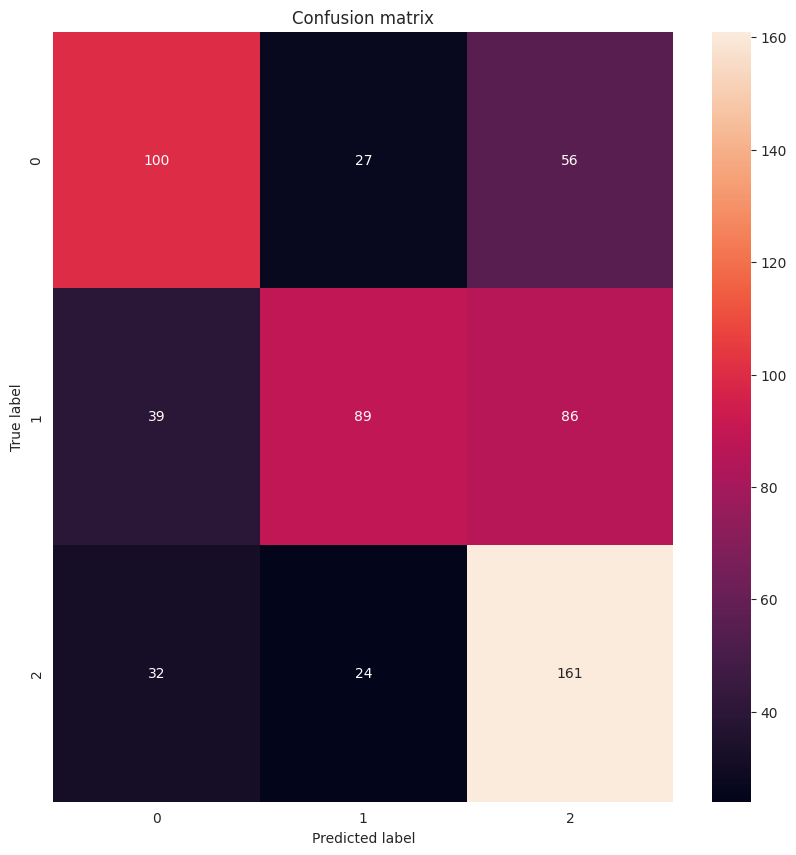

In [5]:
# import plot_model, confusion_matrix, plt, sns
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# print best model accuracy
print('Best Model Accuracy: %.3f' % best_acc)


# plot best model
plot_model(best_model, to_file='best_model_CNNBILSTM_binary.png', show_shapes=True, show_layer_names=True)
# confusion matrix
y_pred = best_model.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_scores, axis=1)
cm = confusion_matrix(y_true, y_pred)
# plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

